In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/model-weights/model_weights_2.pth
/kaggle/input/model-weights/model_weights.pth


In [ ]:
!pip install medmnist

# BloodMNIST Dataset (3 channels (RGB) images)

In [1]:
from medmnist import BloodMNIST

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader , ConcatDataset
aug1_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])

aug2_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(degrees=200),
    transforms.ColorJitter(brightness=0.12, contrast=0.08),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
train_aug1_dataset = BloodMNIST(split="train",download=True,transform=aug1_transform)
train_aug2_dataset = BloodMNIST(split="train",download=True,transform=aug2_transform)
train_orig_dataset = BloodMNIST(split="train",download=True,transform=base_transform)
train_dataset = ConcatDataset([train_orig_dataset,train_aug1_dataset,train_aug2_dataset])

test_dataset = BloodMNIST(split="test",download=True,transform=base_transform)
val_dataset = BloodMNIST(split="val",download=True,transform=base_transform)

In [5]:
train_orig_dataset

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC B

In [6]:
train_loader  = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
val_loader    = DataLoader(val_dataset  , batch_size=24, shuffle=False, num_workers=4)
test_loader   = DataLoader(test_dataset , batch_size=24, shuffle=False, num_workers=4)

['basophil', 'eosinophil', 'erythroblast', 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
#### Train dataset ####


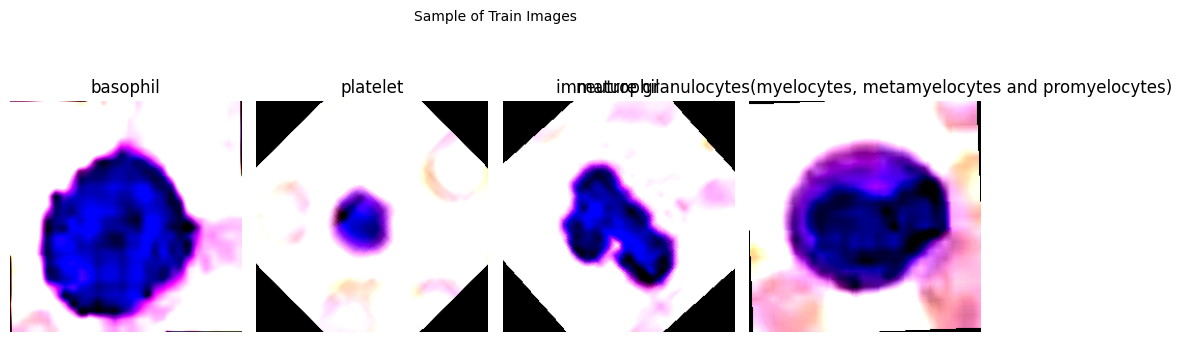

#### Val dataset ####


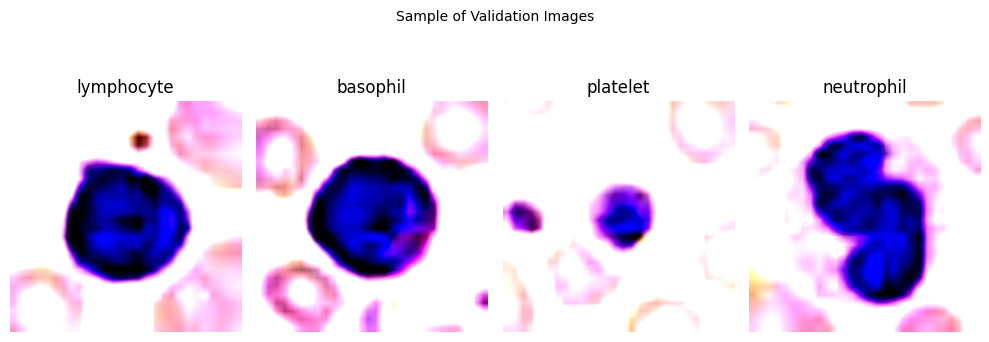

In [31]:
import matplotlib.pyplot as plt

class_names = list(train_aug1_dataset.info["label"].values())
print(class_names)
def showthem(subset='train'):
    plt.figure(figsize=(10, 4))
    loader = train_loader if subset=='train' else val_loader
    title = 'Sample of Train Images' if subset=='train' else 'Sample of Validation Images'
    data_iter = iter(loader)
    images, labels = next(data_iter)

    for i in range(4):
        plt.subplot(1, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis('off')

    plt.suptitle(title, size=10)
    plt.tight_layout()
    plt.show()

print(f"#### Train dataset ####")
showthem("train")


print(f"#### Val dataset ####")
showthem("val")

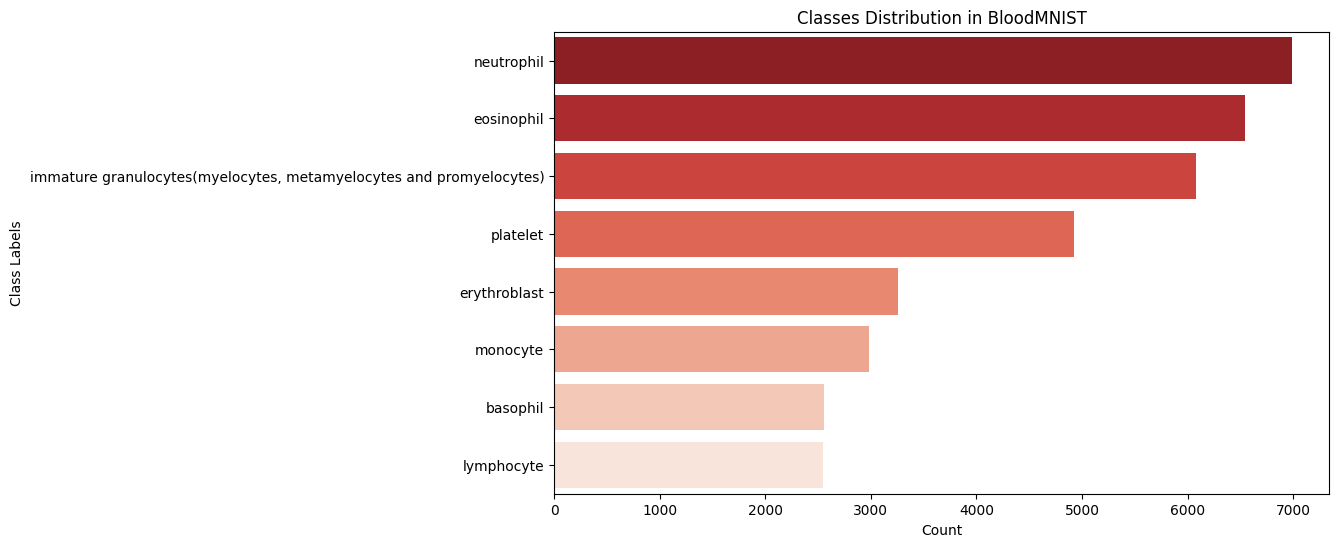

In [32]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get class labels (names)
class_labels = list(train_aug1_dataset.info["label"].values())

# Count occurrences of each class
class_counts = Counter(train_aug1_dataset.labels.squeeze().tolist())
class_counts += Counter(train_orig_dataset.labels.squeeze().tolist())
class_counts += Counter(train_aug2_dataset.labels.squeeze().tolist())

# Build dataframe
dd = pd.DataFrame({
    'labels': class_labels,
    'counts': [class_counts[i] for i in range(len(class_labels))]
})

# Sort and plot
dd = dd.sort_values(by='counts', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='counts', y='labels', data=dd, palette='Reds_r')
plt.xlabel('Count')
plt.ylabel('Class Labels')
plt.title('Classes Distribution in BloodMNIST')
plt.show()

## Vision Transformer Model (building blocks)

In [77]:
from typing import Optional, Tuple
import torch 
import torch.nn as nn

class ViTConfig():
    def __init__(
        self,
        hidden_size = 768, ## Embedding size
        inter_size = 3072, ## Linear layer in the feed forward network
        num_hidden_layers = 12,
        num_attention_heads = 12,
        num_channels=3, ## RGB images
        image_size = 224,
        patch_size=16, ## size of the patch (each image will be divided into patches)
        layer_norm_eps=1e-6,
        attention_dropout=0.1,
        num_image_tokens:int=None, ## number of embeddings for each image
        **kwargs
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.inter_size = inter_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_channels = num_channels
        self.image_size = image_size
        self.patch_size = patch_size
        self.layer_norm_eps = layer_norm_eps
        self.attention_dropout = attention_dropout
        self.num_image_tokens =num_image_tokens


class ViTEmbeddings(nn.Module):
    def __init__(self , config:ViTConfig):
        super().__init__()
        self.config = config
        self.emb_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        
        self.patch_embedding = nn.Conv2d( ## extracting information from the image , patch by patch without overlapping
            in_channels=config.num_channels,
            out_channels=self.emb_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid", ## ensure no padding is added
        )
        self.num_patches = (self.image_size // self.patch_size) **2
        self.num_positions = self.num_patches + 1 
        self.Pos_Embedding = nn.Embedding(self.num_positions,self.emb_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions,device=device).expand((1,-1)),
            persistent=False,
        )
        self.cls_token = nn.Parameter(torch.zeros(1,1,self.emb_dim))
        
    def forward(self,pixel_values:torch.Tensor) -> torch.Tensor : 
        batch_size,_, height , width = pixel_values.shape ## (batch_size, channels, height, width) 
        ## (batch_size, channels, height, width) ==> (batch_size, emb_dim, Num_patches_H, Num_patches_W)
        patch_embeddings = self.patch_embedding(pixel_values)
        ## (batch_size, emb_dim, Num_patches_H, Num_patches_W) ==> (batch_size, emb_dim, Num_patches) / Num_patches = Num_patches_H * Num_patches_W
        embeddings = patch_embeddings.flatten(2)
        ## (batch_size, emb_dim, Num_patches) ==> (batch_size, Num_patches, emb_dim)
        embeddings = embeddings.transpose(1,2)
        cls_tkens = self.cls_token.expand(batch_size,-1,-1)
        embeddings = torch.cat((cls_tkens,embeddings),dim=1)
        ## Add positional embedding for each patch
        embeddings = embeddings + self.Pos_Embedding(self.position_ids)
        ## (batch_size, Num_patches, emb_dim)
        return embeddings 

class ViTMLP(nn.Module):
    def __init__(self , config:ViTConfig):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size , config.inter_size)
        self.fc2 = nn.Linear(config.inter_size , config.hidden_size)

    def forward(self,embeddings) : 
        upper_embeddings = self.fc1(embeddings)
        upper_embeddings = nn.functional.gelu(upper_embeddings,approximate="tanh")
        return self.fc2(upper_embeddings)
            
        
class ViTSelfAttention(nn.Module):
    def __init__(self , config:ViTConfig):
        super().__init__()
        self.config = config
        self.emb_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.emb_dim // self.num_heads
        self.scale = self.head_dim ** -0.5 ## (for the scaled dot product attention)
        self.dropout = config.attention_dropout
        
        self.W_k = nn.Linear(self.emb_dim,self.emb_dim) 
        self.W_q = nn.Linear(self.emb_dim,self.emb_dim) 
        self.W_v = nn.Linear(self.emb_dim,self.emb_dim) 
        self.W_o = nn.Linear(self.emb_dim,self.emb_dim) 
    
    def forward(self,embeddings:torch.Tensor) -> Tuple[torch.Tensor,Optional[torch.Tensor]]:
        ## (batch_size, Num_patches, emb_dim)
        batch_size, N_patches, _ = embeddings.size()
        queries = self.W_q(embeddings)
        keys    = self.W_k(embeddings)
        values  = self.W_v(embeddings)
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_heads, Num_patches, head_dim)
        queries = queries.view(batch_size,N_patches,self.num_heads,self.head_dim).transpose(1,2)
        keys    = keys.view(batch_size,N_patches,self.num_heads,self.head_dim).transpose(1,2)
        values  = values.view(batch_size,N_patches,self.num_heads,self.head_dim).transpose(1,2)
        ## (batch_size, Num_heads, Num_patches, head_dim) @ (batch_size, Num_heads, head_dim, Num_patches)
        attn_weights = (torch.matmul(queries,keys.transpose(2,3))*self.scale) 
        ## attention weights : (batch_size, Num_heads, Num_patches, Num_patches)
        ## softmax , applied by rows
        attn_weights = nn.functional.softmax(attn_weights,dim=-1,dtype=torch.float32).to(queries.dtype)
        attn_weights = nn.functional.dropout(attn_weights,p=self.dropout,training=self.training)
        ## (batch_size, Num_heads, Num_patches, Num_patches) @ (batch_size, Num_heads, Num_patches, head_dim)
        ## attention scores : (batch_size, Num_heads, Num_patches, head_dim)
        attn_scores = torch.matmul(attn_weights,values)
        ## attention scores : (batch_size, Num_heads, Num_patches, head_dim) ==> (batch_size, Num_patches, Num_heads, head_dim)
        attn_scores = attn_scores.transpose(1,2).contiguous()  
        ## (batch_size, Num_patches, Num_heads, head_dim) ==> (batch_size, Num_patches, emb_dim)
        attn_scores = attn_scores.reshape(batch_size,N_patches,self.emb_dim)
        ## Mixing the results of each head with the rest of heads that were calculated separately 
        output = self.W_o(attn_scores)
        
        return output , attn_weights 
    
        
class ViTEncoderLayer(nn.Module):
    def __init__(self , config:ViTConfig):
        super().__init__()
        self.emb_dim = config.hidden_size
        self.self_attn = ViTSelfAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.emb_dim,eps=config.layer_norm_eps)
        self.mlp = ViTMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.emb_dim,eps=config.layer_norm_eps)
        
    def forward(self,embeddings:torch.Tensor) -> torch.Tensor :
        ## residual connection (batch_size, Num_patches, emb_dim)
        residual = embeddings
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_patches, emb_dim)
        embeddings = self.layer_norm1(embeddings)
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_patches, emb_dim) 
        embeddings, _ = self.self_attn(embeddings)
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_patches, emb_dim) 
        embeddings = embeddings + residual
        residual = embeddings
        embeddings = self.layer_norm2(embeddings)
        embeddings = self.mlp(embeddings)
        ## (batch_size, Num_patches, emb_dim) ==> (batch_size, Num_patches, emb_dim) 
        embeddings = embeddings + residual
        
        return embeddings
    
    
    
class ViTEncoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.layers = nn.ModuleList(
            [ViTEncoderLayer(self.config) for _ in range(config.num_hidden_layers)]
        )
    def forward(self,embeddings:torch.Tensor) -> torch.Tensor:
        for layer in self.layers : 
            embeddings = layer(embeddings)
        return embeddings            
    
    

class ViTTransformer(nn.Module):
    def __init__(self , config:ViTConfig):
        super().__init__()
        self.config = config
        emb_dim = config.hidden_size
        self.embeddings = ViTEmbeddings(config) ## extract patches
        self.encoder = ViTEncoder(config)       ## encoder of the transformer (series of layers)
        self.post_layerNorm = nn.LayerNorm(emb_dim,eps=config.layer_norm_eps)
    def forward(self,pixel_values:torch.Tensor) -> torch.Tensor:
        ## pixel values : (batch_size, channels, height, width) ==> (batch_size, Num_patches, emb_dim)
        embeddings = self.embeddings(pixel_values)
        
        encoded_embeddings = self.encoder(embeddings) ## Convolution , split into patches , flattening + Positional Encoding
        encoded_embeddings = self.post_layerNorm(encoded_embeddings) 
        return encoded_embeddings
        
        
class ViTModel(nn.Module):
    def __init__(self , config:ViTConfig):
        super().__init__()
        self.config = config
        self.VisionModel = ViTTransformer(config)
        
    def forward(self,pixel_values) -> Tuple:
        ## (batch_size, channels , height ,width) ==> (batch_size, num_patches, emb_dim)
        return self.VisionModel(pixel_values)
        

In [78]:
class ViTForImageClassification(nn.Module):
    def __init__(self, config: ViTConfig, num_classes: int):
        super().__init__()
        self.vision_model = ViTTransformer(config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        embeddings = self.vision_model(pixel_values)  # (B, num_patches+1, emb_dim)
        cls_embedding = embeddings[:,0,:]  # take [CLS] token
        logits = self.classifier(cls_embedding)
        return logits

In [9]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [79]:
config = ViTConfig()
model = ViTForImageClassification(config, num_classes=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)

In [80]:
model

ViTForImageClassification(
  (vision_model): ViTTransformer(
    (embeddings): ViTEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (Pos_Embedding): Embedding(197, 768)
    )
    (encoder): ViTEncoder(
      (layers): ModuleList(
        (0-11): 12 x ViTEncoderLayer(
          (self_attn): ViTSelfAttention(
            (W_k): Linear(in_features=768, out_features=768, bias=True)
            (W_q): Linear(in_features=768, out_features=768, bias=True)
            (W_v): Linear(in_features=768, out_features=768, bias=True)
            (W_o): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): ViTMLP(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_a

In [39]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_f1s = []

from sklearn.metrics import f1_score
from tqdm import tqdm

In [40]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # halve LR every 5 epochs


num_epochs = 10 
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for imgs, labels in tqdm(train_loader,desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels.squeeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels.squeeze(1)).sum().item()
        total += labels.size(0)
    scheduler.step()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # --- Validation ---
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels.squeeze(1))
            val_running_loss += loss.item() * imgs.size(0)
            
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels.squeeze(1)).sum().item()
            val_total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_f1s.append(val_f1)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")


Epoch [1/10]: 100%|██████████| 1495/1495 [10:47<00:00,  2.31it/s]


Epoch 1/10 | Train Loss: 0.5757 | Val Loss: 0.2668 | Val F1: 0.9069


Epoch [2/10]: 100%|██████████| 1495/1495 [10:47<00:00,  2.31it/s]


Epoch 2/10 | Train Loss: 0.2655 | Val Loss: 0.2393 | Val F1: 0.9178


Epoch [3/10]: 100%|██████████| 1495/1495 [10:46<00:00,  2.31it/s]


Epoch 3/10 | Train Loss: 0.2096 | Val Loss: 0.2189 | Val F1: 0.9208


Epoch [4/10]: 100%|██████████| 1495/1495 [10:47<00:00,  2.31it/s]


Epoch 4/10 | Train Loss: 0.1783 | Val Loss: 0.1891 | Val F1: 0.9367


Epoch [5/10]: 100%|██████████| 1495/1495 [10:47<00:00,  2.31it/s]


Epoch 5/10 | Train Loss: 0.1575 | Val Loss: 0.1690 | Val F1: 0.9388


Epoch [6/10]: 100%|██████████| 1495/1495 [10:46<00:00,  2.31it/s]


Epoch 6/10 | Train Loss: 0.0978 | Val Loss: 0.1250 | Val F1: 0.9574


Epoch [7/10]: 100%|██████████| 1495/1495 [10:46<00:00,  2.31it/s]


Epoch 7/10 | Train Loss: 0.0884 | Val Loss: 0.1812 | Val F1: 0.9425


Epoch [8/10]: 100%|██████████| 1495/1495 [10:46<00:00,  2.31it/s]


Epoch 8/10 | Train Loss: 0.0777 | Val Loss: 0.1277 | Val F1: 0.9583


Epoch [9/10]: 100%|██████████| 1495/1495 [10:46<00:00,  2.31it/s]


Epoch 9/10 | Train Loss: 0.0714 | Val Loss: 0.1283 | Val F1: 0.9581


Epoch [10/10]: 100%|██████████| 1495/1495 [10:47<00:00,  2.31it/s]


Epoch 10/10 | Train Loss: 0.0626 | Val Loss: 0.1454 | Val F1: 0.9522


## Model Evaluation

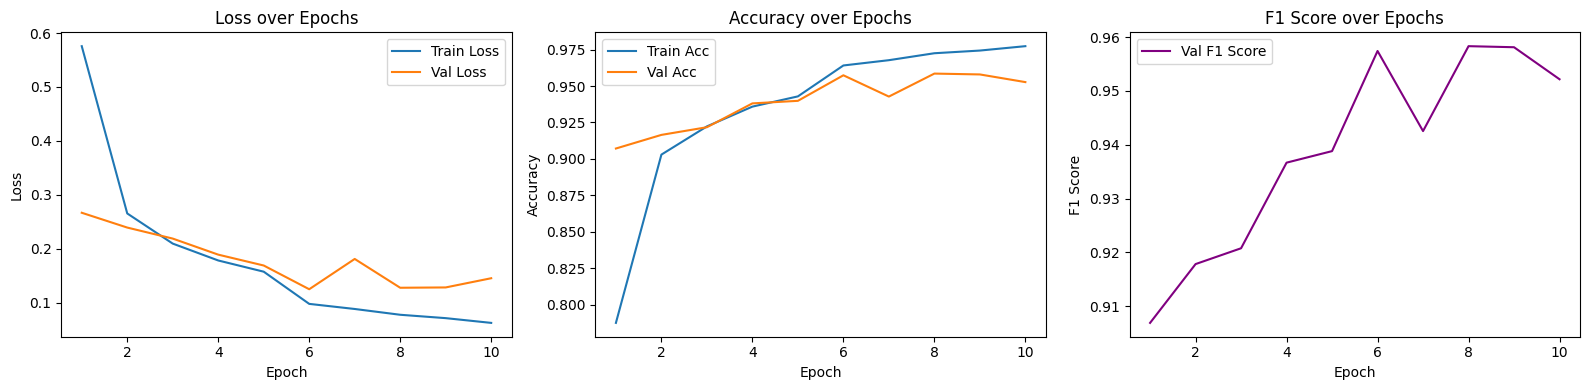

In [41]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, val_f1s, label='Val F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

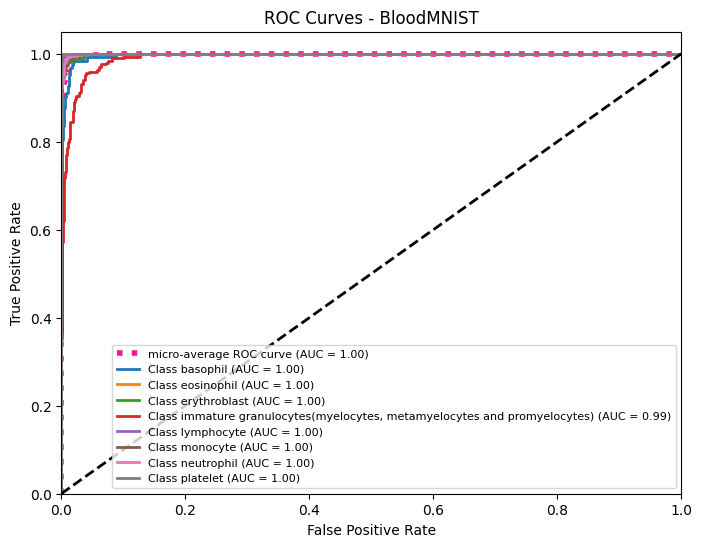

In [42]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

n_classes = len(class_names)

all_probs = [] 
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader : 
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels.squeeze(1))
        val_running_loss += loss.item() * imgs.size(0)

        probs = torch.softmax(outputs, dim=1)   # probabilities
        _, preds = torch.max(probs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- after loop ---
all_labels_bin = label_binarize(all_labels, classes=list(range(n_classes)))
all_probs = np.array(all_probs)

# Compute ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot per-class ROC
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - BloodMNIST')
plt.legend(loc="lower right", fontsize=8)
plt.show()


In [16]:
## confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1) 
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


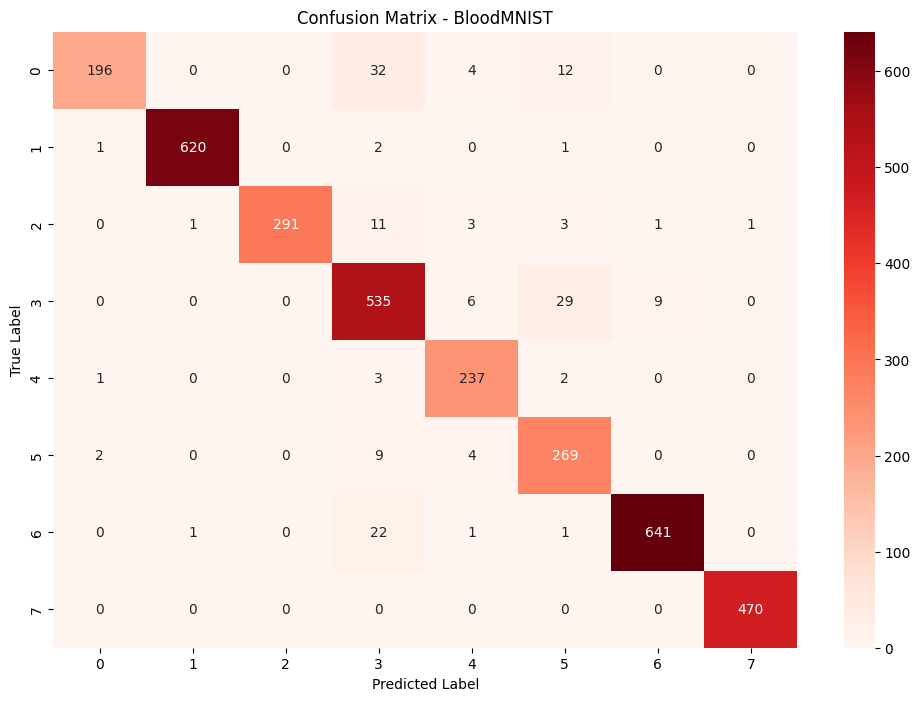

In [29]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BloodMNIST")
plt.show()

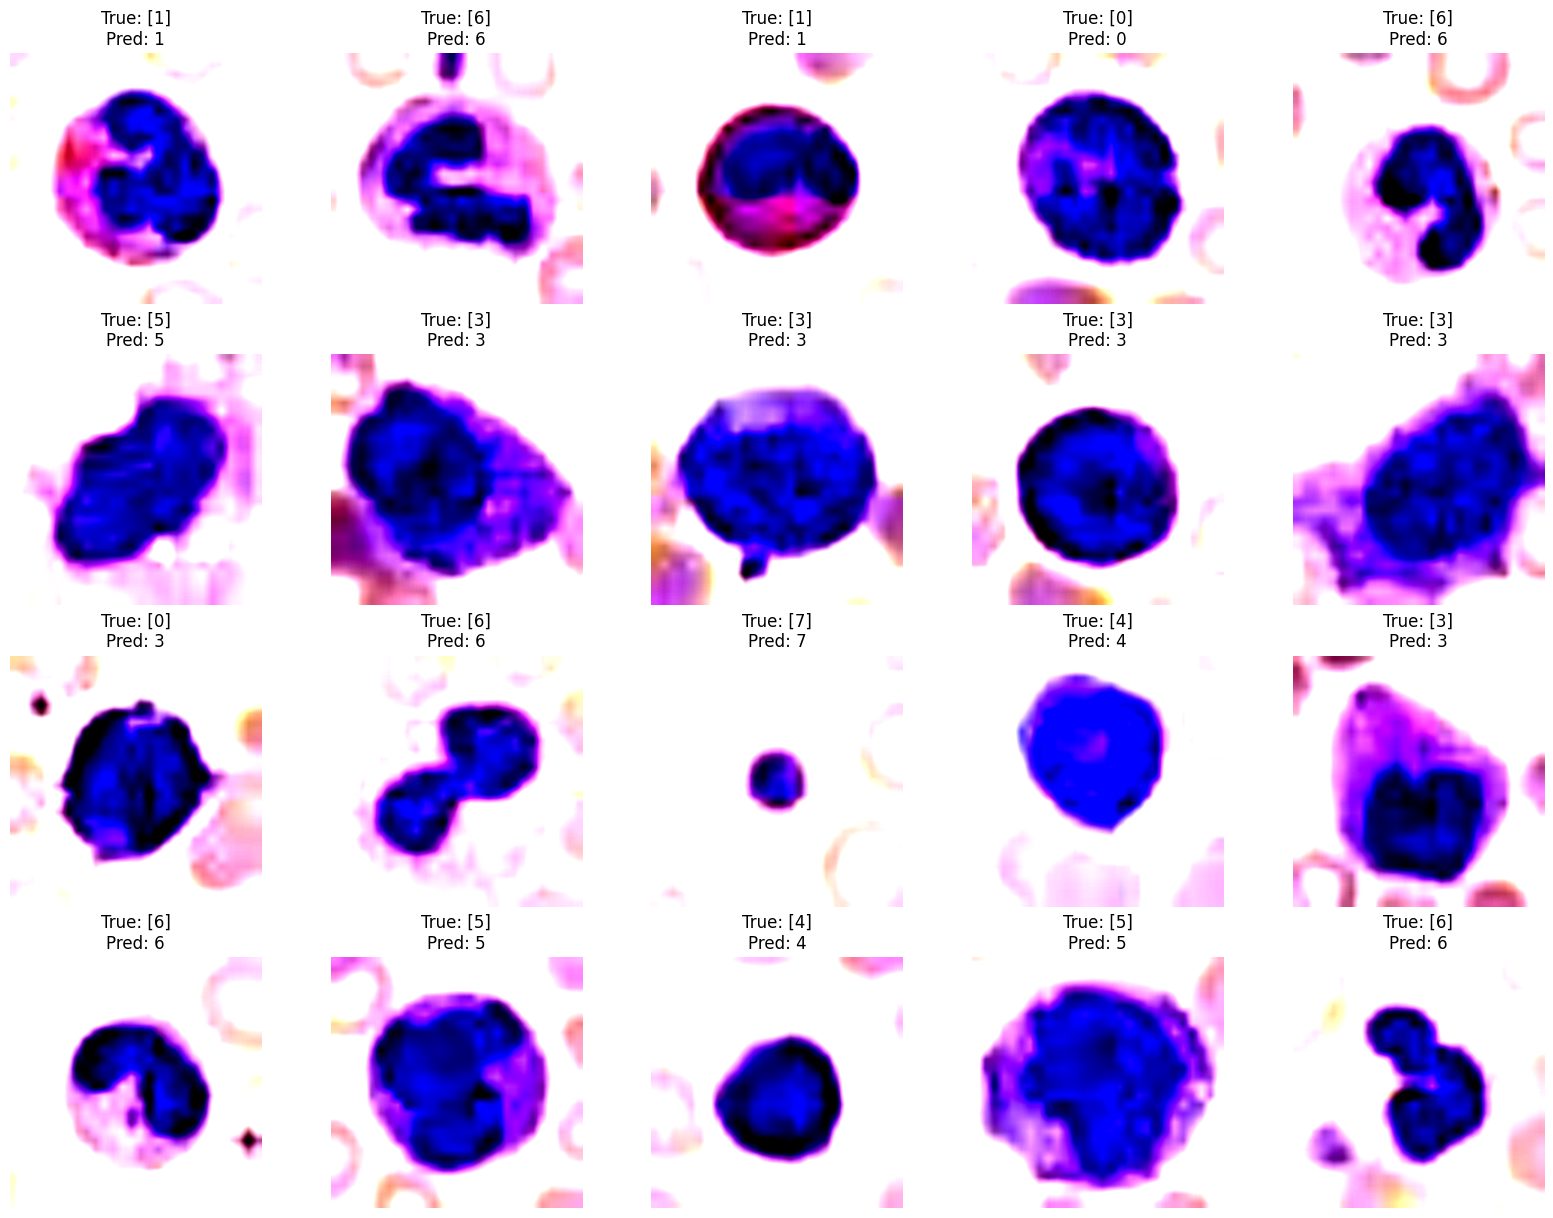

In [47]:
import torch
import matplotlib.pyplot as plt
import random

# Set model to evaluation
model.eval()
class_labels = list(train_aug1_dataset.info["label"].values())
# Mapping from indices to class names
#idx_to_class = {v: k for k, v in enumerate(class_labels)}

# Pick a few random indices
num_samples = 20
indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(20, 15))

for i, idx in enumerate(indices):
    img, true_label_idx = test_dataset[idx]
    
    # Move to batch format (1, C, H, W)
    input_tensor = img.unsqueeze(0).to("cuda")  # or "cuda" if using GPU
    with torch.no_grad():
        output = model(input_tensor)
        predicted_label_idx = torch.argmax(output, dim=1).item()
    
    plt.subplot(4, num_samples//4, i + 1)
    img_np = img.permute(1, 2, 0).numpy()
    plt.imshow(img_np)
    plt.title(f"True: {true_label_idx}\nPred: {predicted_label_idx}")
    plt.axis("off")

plt.show()

## Inference Pipeline

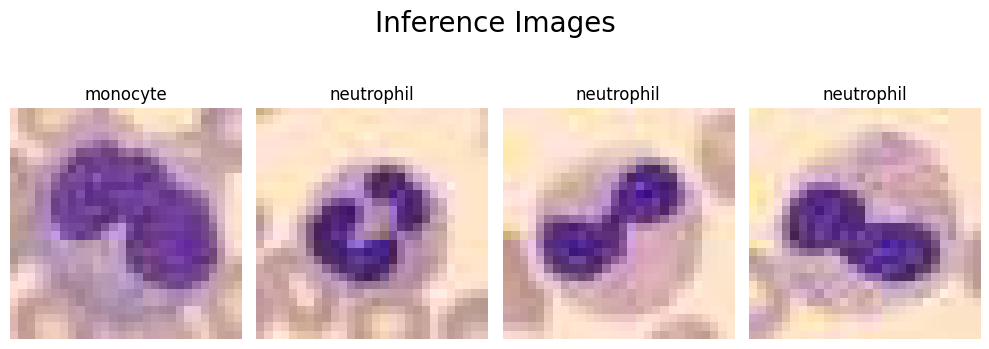

In [76]:
## Inference pipeline , (one image at a time)
Inference_data = BloodMNIST(split="test",download=True)
class_names = list(train_aug1_dataset.info["label"].values())

plt.figure(figsize=(10, 4))
title = "Inference Images"
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img , label = Inference_data[i+10]
    #img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[int(label.item())])
    plt.axis('off')

plt.suptitle(title, size=20)
plt.tight_layout()
plt.show()

In [74]:
def predict_class(img_indice,class_names):
    img,label = Inference_data[img_indice]
    img_tensor = base_transform(img).unsqueeze(0).to(device) ## to tensor / add batch dimension / to device 
    with torch.no_grad():
        outputs = model(img_tensor)
        pred = torch.argmax(outputs, dim=1).item()
    plt.imshow(img)
    plt.title(class_names[int(label.item())])
    plt.axis('off')
    plt.show()
    print(f"True Label : {class_names[pred]} \nPredicted Label : {class_names[int(label.item())]}")

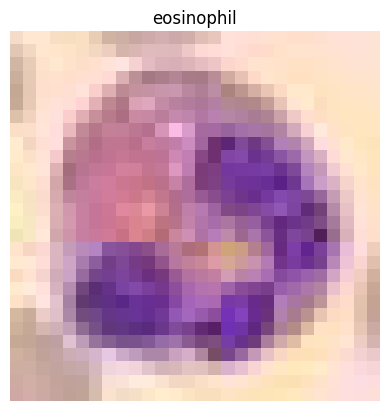

True Label : eosinophil 
Predicted Label : eosinophil


In [75]:
predict_class(51,class_names)